<a href="https://colab.research.google.com/github/alex-smith-uwec/AI_Spring2025/blob/main/FrozenLake_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt


In [27]:

# Initialize FrozenLake environment
env = gym.make("FrozenLake-v1", desc=None, map_name="4x4", is_slippery=True, render_mode=None)
n_actions = env.action_space.n
n_states = env.observation_space.n


In [28]:
def print_frozen_lake_layout(env):
    desc = env.unwrapped.desc.astype(str)
    size = desc.shape[0]

    for i in range(size):
        row = ""
        for j in range(size):
            cell = f" {desc[i][j]} "
            row += f"|{cell}"
        row += "|"
        print(row)
        print("-" * len(row))
print_frozen_lake_layout(env)

| S | F | F | F |
-----------------
| F | H | F | H |
-----------------
| F | F | F | H |
-----------------
| H | F | F | G |
-----------------


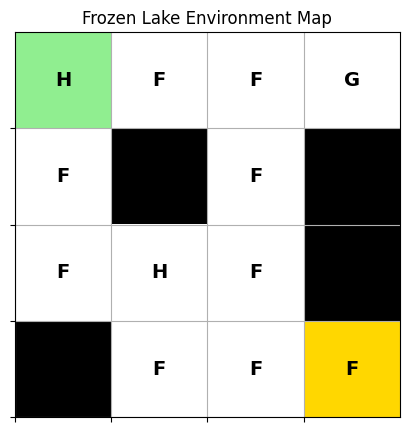

In [22]:


def plot_frozen_lake_map(env):
    desc = env.unwrapped.desc.astype(str)
    size = desc.shape[0]

    # Map characters to colors
    cmap = {
        'S': 'lightgreen',  # Start
        'F': 'white',       # Frozen
        'H': 'black',       # Hole
        'G': 'gold'         # Goal
    }

    # Convert characters to numerical values for imshow
    # Create a numerical representation of the grid
    numerical_grid = np.zeros(desc.shape, dtype=int)
    for i in range(size):
        for j in range(size):
            numerical_grid[i, j] = list(cmap.keys()).index(desc[i, j])

    # Create a colormap with the desired colors
    from matplotlib.colors import ListedColormap
    color_list = list(cmap.values())
    custom_cmap = ListedColormap(color_list)


    fig, ax = plt.subplots(figsize=(5, 5))
    # Use the numerical grid and custom colormap
    ax.imshow(numerical_grid, extent=(0, size, 0, size), origin='upper', cmap=custom_cmap)

    # Add annotations
    for i in range(size):
        for j in range(size):
            char = desc[i, j]
            ax.text(j + 0.5, i + 0.5, char, ha='center', va='center', fontsize=14, weight='bold')

    ax.set_xticks(np.arange(size))
    ax.set_yticks(np.arange(size))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(True)
    ax.set_title("Frozen Lake Environment Map")
    plt.show()

plot_frozen_lake_map(env)

In [4]:
# Q-learning parameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Initial exploration probability
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 5000


In [5]:

# Initialize Q-table
Q = np.zeros((n_states, n_actions))

# Store rewards per episode
rewards_per_episode = []

# Q-learning loop
for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        # Choose action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(Q[state, :])  # Exploit

        next_state, reward, done, truncated, _ = env.step(action)

        # Update Q-value
        Q[state, action] = (1 - alpha) * Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state, :]))

        state = next_state
        total_reward += reward

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_per_episode.append(total_reward)

    if (episode + 1) % 500 == 0:
        print(f"Episode {episode + 1}/{num_episodes}, Epsilon: {epsilon:.4f}, Avg Reward: {np.mean(rewards_per_episode[-100:]):.2f}")


Episode 500/5000, Epsilon: 0.0816, Avg Reward: 0.14
Episode 1000/5000, Epsilon: 0.0100, Avg Reward: 0.12
Episode 1500/5000, Epsilon: 0.0100, Avg Reward: 0.24
Episode 2000/5000, Epsilon: 0.0100, Avg Reward: 0.18
Episode 2500/5000, Epsilon: 0.0100, Avg Reward: 0.07
Episode 3000/5000, Epsilon: 0.0100, Avg Reward: 0.22
Episode 3500/5000, Epsilon: 0.0100, Avg Reward: 0.21
Episode 4000/5000, Epsilon: 0.0100, Avg Reward: 0.08
Episode 4500/5000, Epsilon: 0.0100, Avg Reward: 0.23
Episode 5000/5000, Epsilon: 0.0100, Avg Reward: 0.12


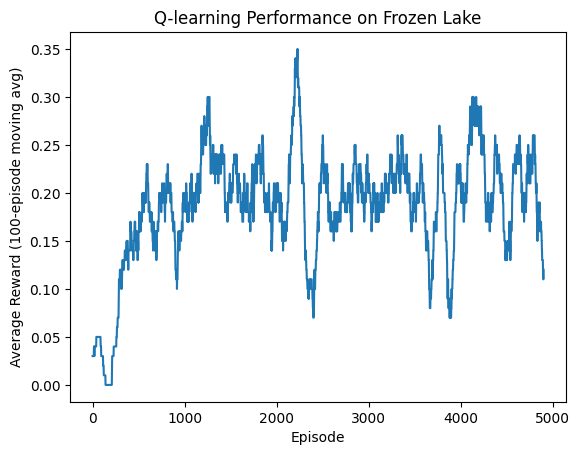

Learned Q-table:
[[1.24427518e-01 1.27113730e-01 1.20752405e-01 1.29298963e-01]
 [1.09474550e-01 8.38044170e-02 6.17881722e-02 1.34474493e-01]
 [1.43199647e-01 1.27223491e-01 1.31776300e-01 1.16500572e-01]
 [8.73564812e-02 2.83040865e-02 1.19372431e-03 1.22040502e-04]
 [2.23802459e-02 1.48637957e-04 9.17210004e-02 1.40931533e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.06079056e-01 5.85313188e-02 1.75761930e-01 7.15472122e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.11809930e-02 3.79944728e-04 1.15554367e-01 2.05988808e-04]
 [1.64167516e-01 1.55205546e-01 2.23964205e-01 6.33163408e-02]
 [2.44213240e-01 2.02624237e-01 2.94769080e-01 4.55887781e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.91611986e-01 2.54972146e-01 5.24866961e-01 1.79971215e-01]
 [3.00387514e-01 7.66701840e-01 5.30477167e-01 4.10947534e-01]
 [0.00000000e+00 0.00000000e+00 0.0000

In [6]:
# Plot learning curve
plt.plot(np.convolve(rewards_per_episode, np.ones(100)/100, mode='valid'))
plt.xlabel("Episode")
plt.ylabel("Average Reward (100-episode moving avg)")
plt.title("Q-learning Performance on Frozen Lake")
plt.show()

# Display learned Q-table
print("Learned Q-table:")
print(Q)

# Value Iteration to find optimal utilities
V = np.zeros(n_states)
threshold = 1e-6
delta = float("inf")
env_unwrapped = env.unwrapped  # Get the raw environment

while delta > threshold:
    delta = 0
    for state in range(n_states):
        v = V[state]
        V[state] = max(sum(prob * (reward + gamma * V[next_state])
                          for prob, next_state, reward, _ in env_unwrapped.P[state][action])
                       for action in range(n_actions))
        delta = max(delta, abs(v - V[state]))

# Display optimal utility values
print("Optimal state values from Value Iteration:")
print(V)

# Compare max Q-values to optimal state values
print("\nState | Max Q-Value | Optimal V-Value | Difference")
print("---------------------------------------------------")
for state in range(n_states):
    max_q = np.max(Q[state, :])
    optimal_v = V[state]
    diff = abs(max_q - optimal_v)
    print(f"{state:5} | {max_q:10.4f} | {optimal_v:10.4f} | {diff:10.4f}")


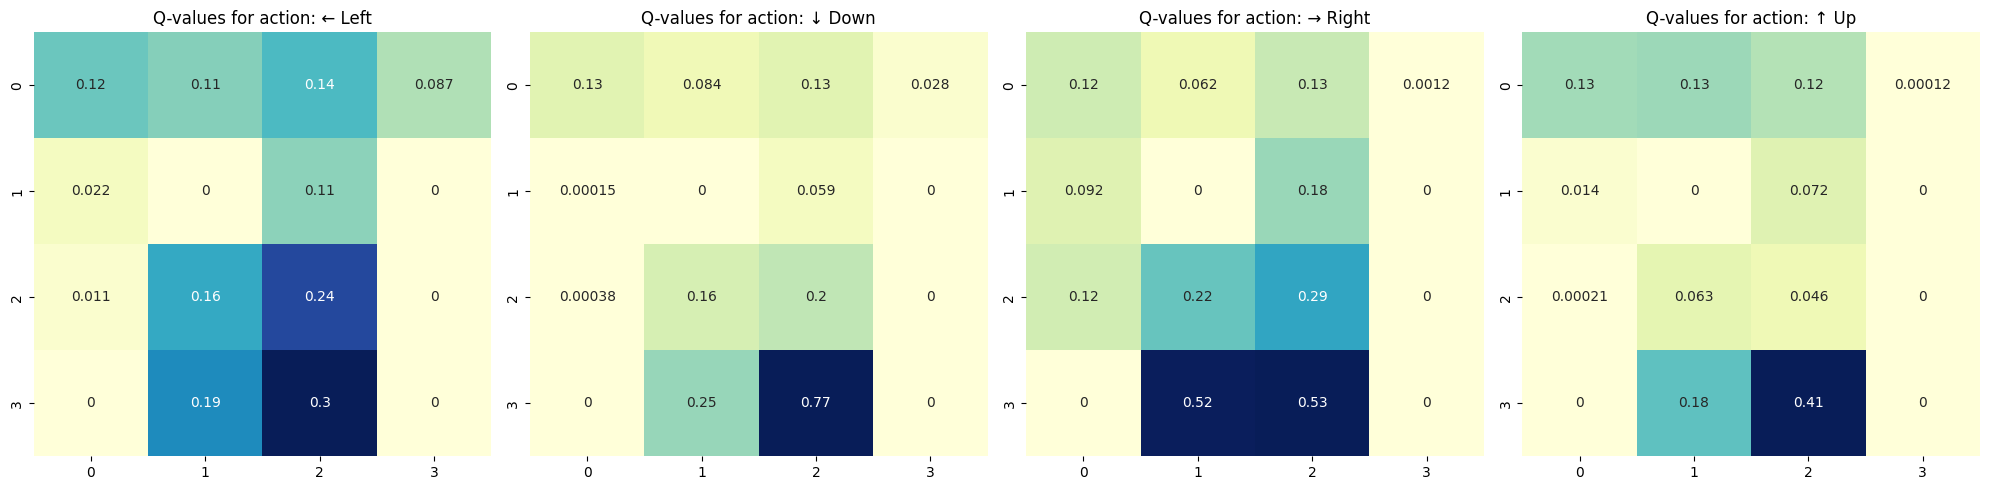

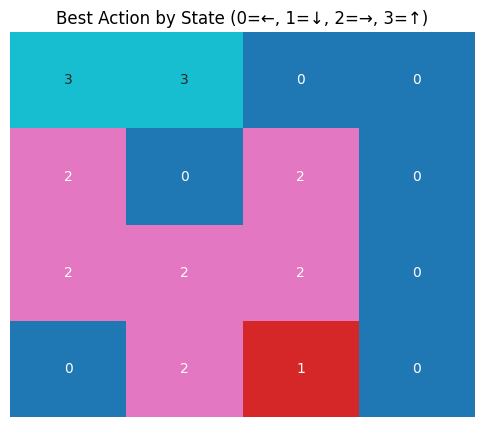

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

action_names = ['← Left', '↓ Down', '→ Right', '↑ Up']
grid_size = int(np.sqrt(n_states))

# Heatmaps for each action
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for a in range(n_actions):
    q_grid = Q[:, a].reshape((grid_size, grid_size))
    sns.heatmap(q_grid, annot=True, cmap='YlGnBu', ax=axs[a], cbar=False)
    axs[a].set_title(f"Q-values for action: {action_names[a]}")
plt.tight_layout()
plt.show()

# Heatmap of best action
best_actions = np.argmax(Q, axis=1).reshape((grid_size, grid_size))
plt.figure(figsize=(6, 5))
sns.heatmap(best_actions, annot=True, cbar=False, cmap='tab10',
            xticklabels=False, yticklabels=False)
plt.title("Best Action by State (0=←, 1=↓, 2=→, 3=↑)")
plt.show()
